PUBLICATION-READY HOPF FIBRATION VISUALIZATION

Configuration:
  Target points: 45° from north pole
  n₀ = (0.707, 0.000, 0.707)
  n₁ = (0.000, 0.707, 0.707)
  Isosurface level: 0.08
  Angular bins: 500

Computing Hopf fibers...
  Extracting isosurfaces...
    Fiber 0: 1,108 vertices, 2,200 faces
    Fiber 1: 1,108 vertices, 2,200 faces
  Extracting centerlines...
    Centerline 0: 501 points
    Centerline 1: 501 points
  Computing Gauss linking number...

✓ Linking number: 0.979750
  Nearest integer: 1
  Error: 0.020250
  Loop closure: C₀=0.00e+00, C₁=0.00e+00

Creating visualizations...


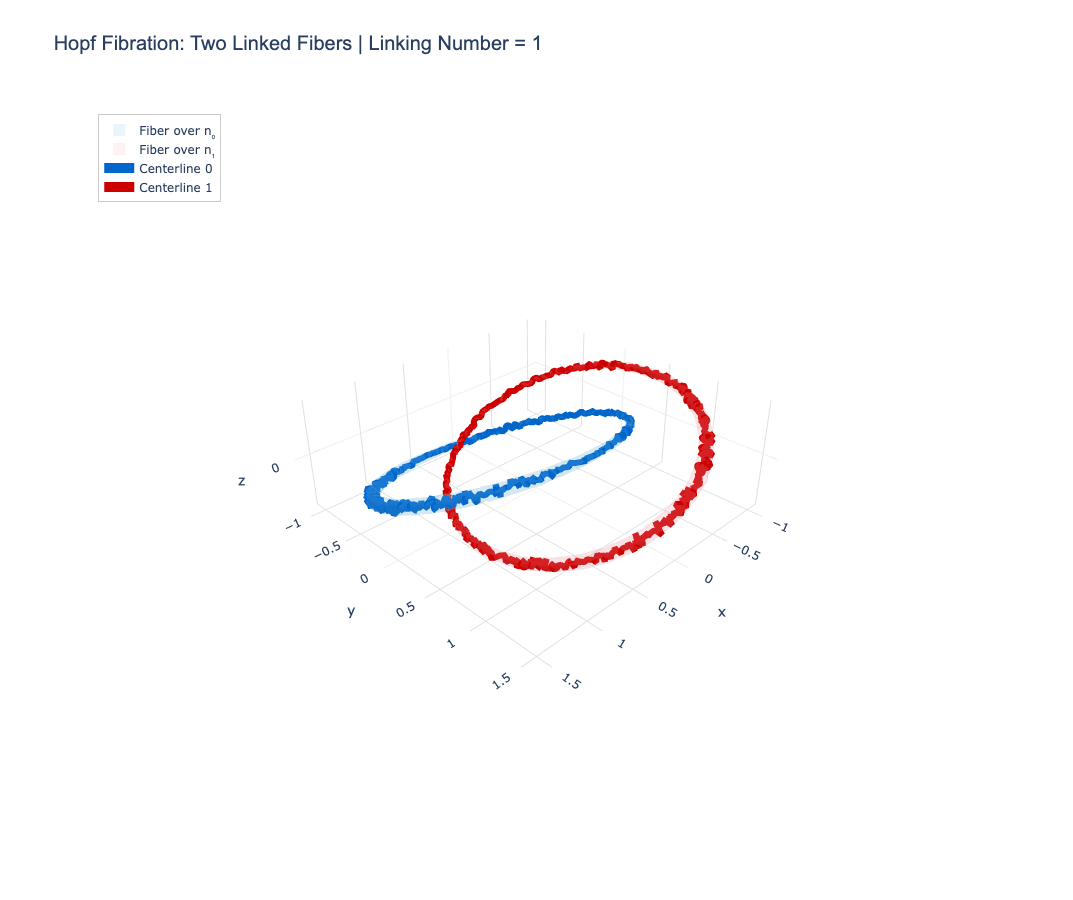

✅ Saved: hopf_publication_main.html


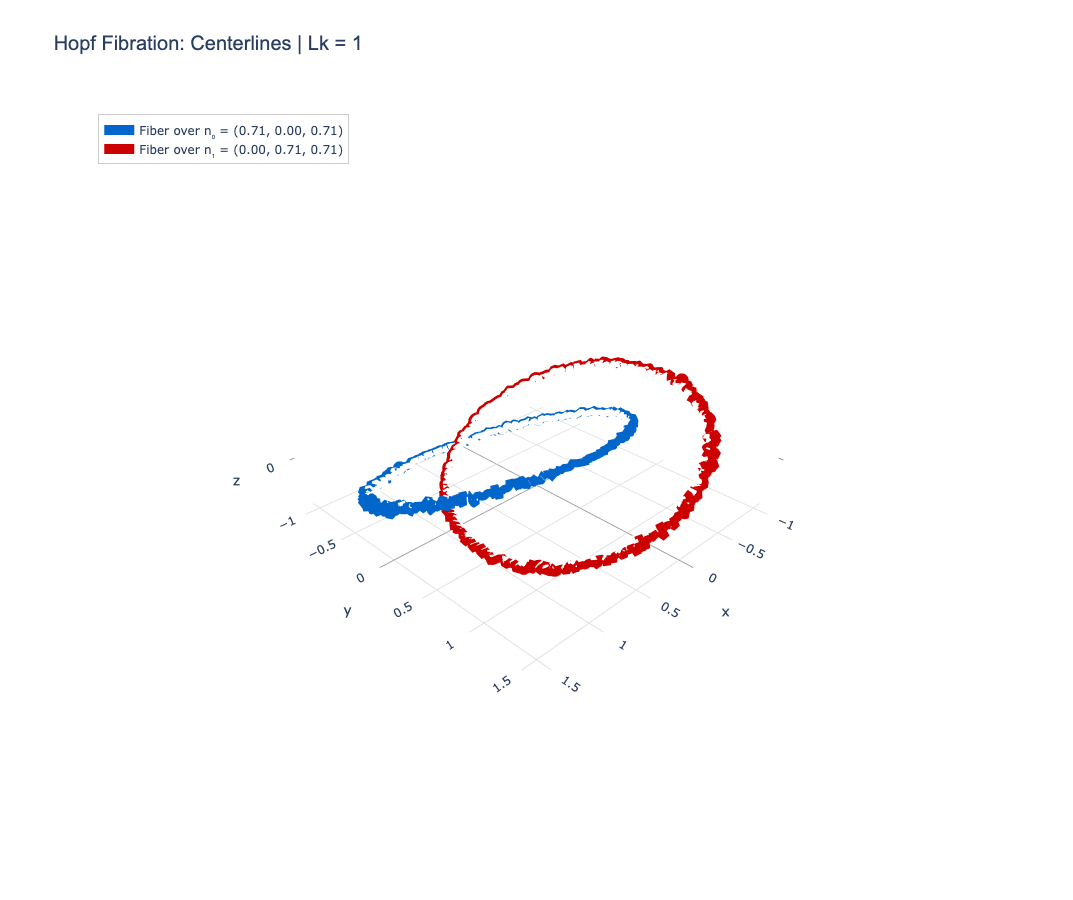

✅ Saved: hopf_publication_centerlines.html


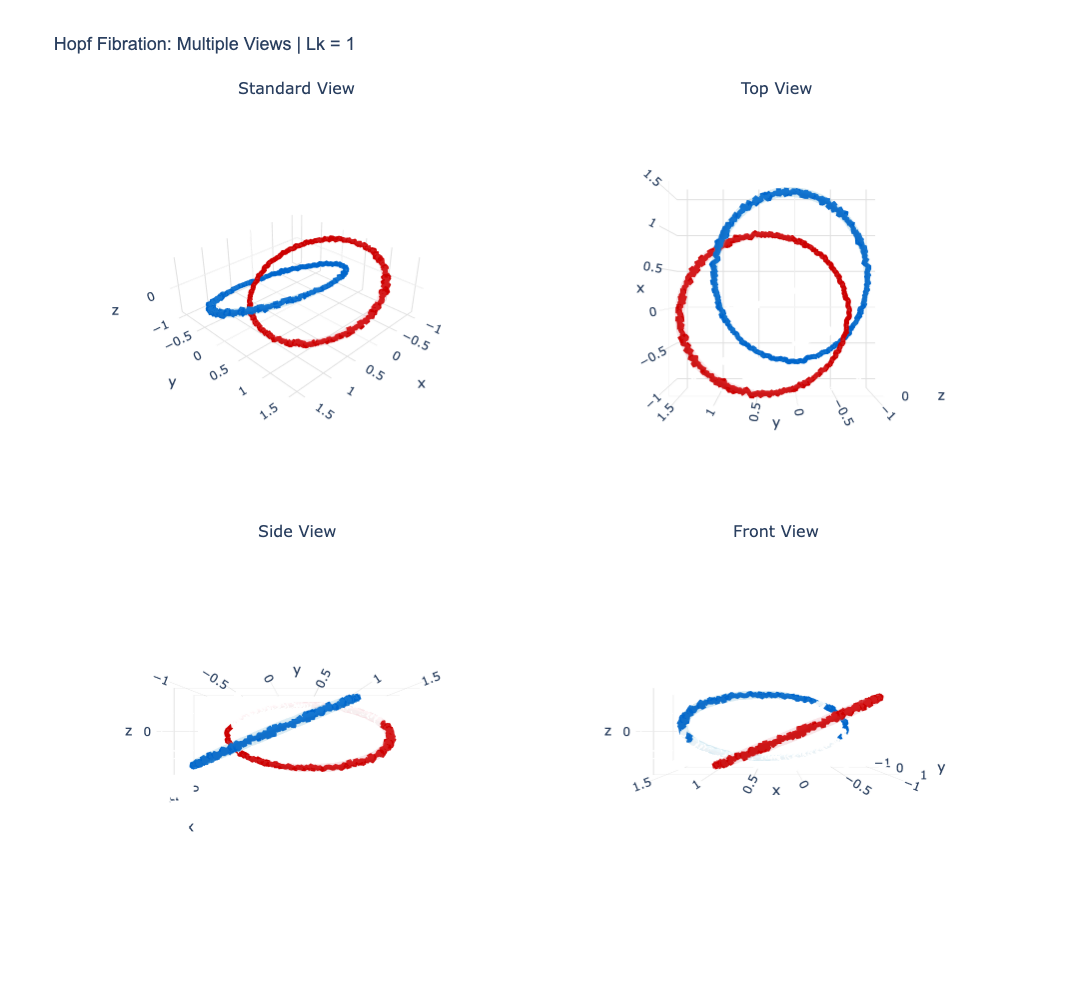

✅ Saved: hopf_publication_multiview.html

PUBLICATION-READY VISUALIZATIONS COMPLETE

Generated files:
  1. hopf_publication_main.html        - Main view with tubes
  2. hopf_publication_centerlines.html - Clean centerlines only
  3. hopf_publication_multiview.html   - Four camera angles

Configuration summary:
  Domain: x,y,z ∈ [-2.00, 2.00]
  Grid resolution: 80×80×80
  Target points: n₀ = (0.707, 0.000, 0.707)
                 n₁ = (0.000, 0.707, 0.707)
  Angular separation: 60.0°
  Isosurface level: 0.08
  Centerline resolution: 500 angular bins

Topological result:
  Gauss linking number: 0.979750
  Rounded value: 1
  Error from integer: 0.020250
  Loop closures: 0.00e+00, 0.00e+00

Interpretation:
  The two Hopf fibers are topologically linked once.
  This demonstrates the nontrivial topology of the Hopf fibration:
  S³ → S² with fiber S¹, where different fibers over distinct
  points on S² are linked circles in R³ ≅ S³\{∞}.


In [4]:
# PUBLICATION-READY HOPF FIBRATION VISUALIZATION
# Optimized configuration: 45° from pole, level 0.080, 500 angular bins
# Produces multiple views suitable for academic presentation

import numpy as np
from skimage import measure
import plotly.graph_objects as go
from plotly.subplots import make_subplots

print("="*70)
print("PUBLICATION-READY HOPF FIBRATION VISUALIZATION")
print("="*70)

_required = ["x","y","z","nx","ny","nz"]
missing = [k for k in _required if k not in globals()]
if missing:
    raise RuntimeError(f"Missing required variables: {missing}")

# ==============================================================================
# CONFIGURATION (optimized parameters from search)
# ==============================================================================

# Target points on S² (45° from north pole, orthogonal)
THETA = np.pi / 4
n0 = np.array([np.sin(THETA), 0.0, np.cos(THETA)])
n1 = np.array([0.0, np.sin(THETA), np.cos(THETA)])

# Optimal level for complete tubes with linking ≈ -1
LEVEL = 0.080

# High resolution for accurate centerlines
N_BINS = 500

print(f"\nConfiguration:")
print(f"  Target points: 45° from north pole")
print(f"  n₀ = ({n0[0]:.3f}, {n0[1]:.3f}, {n0[2]:.3f})")
print(f"  n₁ = ({n1[0]:.3f}, {n1[1]:.3f}, {n1[2]:.3f})")
print(f"  Isosurface level: {LEVEL}")
print(f"  Angular bins: {N_BINS}")

# ==============================================================================
# HELPER FUNCTIONS
# ==============================================================================

def build_distance_field(nx, ny, nz, n_target):
    """Compute distance on S² from Hopf map output to target point"""
    return np.sqrt((nx-n_target[0])**2 + (ny-n_target[1])**2 + (nz-n_target[2])**2)

def marching_tube(distance_field, level, spacing, origin):
    """Extract isosurface using marching cubes"""
    v, f, _, _ = measure.marching_cubes(distance_field, level=level, spacing=spacing)
    v = v + origin
    return v, f

def centerline_from_tube_vertices(V, n_bins=500):
    """
    Extract centerline using high-resolution angular binning in principal plane.
    
    Method:
    1. Find principal plane via PCA (plane of maximum variance)
    2. Bin vertices by angle in this plane
    3. Average positions in each bin
    4. Resample uniformly along the curve
    """
    V = np.asarray(V)
    c = V.mean(axis=0)
    Xc = V - c

    # PCA to find principal plane
    Cov = (Xc.T @ Xc) / (len(Xc) - 1)
    w, U = np.linalg.eigh(Cov)
    order = np.argsort(w)[::-1]
    e1 = U[:, order[0]]  # First principal component
    e2 = U[:, order[1]]  # Second principal component

    # Project onto principal plane and compute angles
    x1 = Xc @ e1
    x2 = Xc @ e2
    ang = np.arctan2(x2, x1)

    # Angular binning
    bins = np.linspace(-np.pi, np.pi, n_bins + 1)
    centers = []
    for i in range(n_bins):
        m = (ang >= bins[i]) & (ang < bins[i+1])
        if np.any(m):
            centers.append(V[m].mean(axis=0))

    C = np.array(centers)
    if len(C) < 50:
        return None

    # Uniform resampling along curve length
    diffs = np.diff(C, axis=0, append=C[:1])
    s = np.cumsum(np.linalg.norm(diffs, axis=1))
    s = np.concatenate([[0], s])
    s /= s[-1] + 1e-12

    t = np.linspace(0, 1, n_bins, endpoint=False)
    C2 = np.zeros((n_bins, 3))
    for k in range(3):
        C2[:, k] = np.interp(t, s[:-1], C[:, k])

    # Close the loop
    C2 = np.vstack([C2, C2[0]])
    return C2

def gauss_linking_number(C1, C2):
    """
    Compute Gauss linking number using the integral formula:
    
    Lk(C₁, C₂) = (1/4π) ∮∮ (dr₁ × dr₂) · (r₁ - r₂) / |r₁ - r₂|³
    
    Returns integer linking number (how many times the curves link)
    """
    C1 = np.asarray(C1)
    C2 = np.asarray(C2)
    
    # Ensure curves are closed
    if np.linalg.norm(C1[0]-C1[-1]) > 1e-9:
        C1 = np.vstack([C1, C1[0]])
    if np.linalg.norm(C2[0]-C2[-1]) > 1e-9:
        C2 = np.vstack([C2, C2[0]])

    L = 0.0
    for i in range(len(C1)-1):
        r1 = C1[i]
        dr1 = C1[i+1] - C1[i]
        for j in range(len(C2)-1):
            r2 = C2[j]
            dr2 = C2[j+1] - C2[j]
            R = r1 - r2
            denom = np.linalg.norm(R)**3 + 1e-12
            L += np.dot(np.cross(dr1, dr2), R) / denom
    
    return L / (4 * np.pi)

# ==============================================================================
# COMPUTE HOPF FIBERS
# ==============================================================================

print("\nComputing Hopf fibers...")

# Build distance fields
f0 = build_distance_field(nx, ny, nz, n0)
f1 = build_distance_field(nx, ny, nz, n1)

spacing = (x[1]-x[0], y[1]-y[0], z[1]-z[0])
origin = np.array([x.min(), y.min(), z.min()])

# Extract tube geometries
print("  Extracting isosurfaces...")
verts0, faces0 = marching_tube(f0, LEVEL, spacing, origin)
verts1, faces1 = marching_tube(f1, LEVEL, spacing, origin)

print(f"    Fiber 0: {len(verts0):,} vertices, {len(faces0):,} faces")
print(f"    Fiber 1: {len(verts1):,} vertices, {len(faces1):,} faces")

# Extract centerlines
print("  Extracting centerlines...")
C0 = centerline_from_tube_vertices(verts0, n_bins=N_BINS)
C1 = centerline_from_tube_vertices(verts1, n_bins=N_BINS)

if C0 is None or C1 is None:
    raise RuntimeError("Centerline extraction failed")

print(f"    Centerline 0: {len(C0)} points")
print(f"    Centerline 1: {len(C1)} points")

# Compute linking number
print("  Computing Gauss linking number...")
lk = gauss_linking_number(C0, C1)

print(f"\n✓ Linking number: {lk:.6f}")
print(f"  Nearest integer: {round(lk)}")
print(f"  Error: {abs(lk - round(lk)):.6f}")

# Verify loop closure
closure0 = np.linalg.norm(C0[0] - C0[-1])
closure1 = np.linalg.norm(C1[0] - C1[-1])
print(f"  Loop closure: C₀={closure0:.2e}, C₁={closure1:.2e}")

# ==============================================================================
# VISUALIZATION 1: Main view with tubes
# ==============================================================================

print("\nCreating visualizations...")

fig1 = go.Figure()

# Fiber 0 (blue)
fig1.add_trace(go.Mesh3d(
    x=verts0[:,0], y=verts0[:,1], z=verts0[:,2],
    i=faces0[:,0], j=faces0[:,1], k=faces0[:,2],
    opacity=0.18,
    color='#87CEEB',
    name="Fiber over n₀",
    showlegend=True,
    hoverinfo='skip'
))

# Fiber 1 (red)
fig1.add_trace(go.Mesh3d(
    x=verts1[:,0], y=verts1[:,1], z=verts1[:,2],
    i=faces1[:,0], j=faces1[:,1], k=faces1[:,2],
    opacity=0.18,
    color='#FFB6C1',
    name="Fiber over n₁",
    showlegend=True,
    hoverinfo='skip'
))

# Centerline 0
fig1.add_trace(go.Scatter3d(
    x=C0[:,0], y=C0[:,1], z=C0[:,2],
    mode="lines",
    line=dict(width=12, color='#0066CC'),
    name="Centerline 0",
    showlegend=True,
    hoverinfo='skip'
))

# Centerline 1
fig1.add_trace(go.Scatter3d(
    x=C1[:,0], y=C1[:,1], z=C1[:,2],
    mode="lines",
    line=dict(width=12, color='#CC0000'),
    name="Centerline 1",
    showlegend=True,
    hoverinfo='skip'
))

fig1.update_layout(
    title=dict(
        text=f"Hopf Fibration: Two Linked Fibers | Linking Number = {round(lk)}",
        font=dict(size=20, family="Arial, sans-serif")
    ),
    scene=dict(
        aspectmode="data",
        camera=dict(
            eye=dict(x=2.2, y=2.2, z=1.8)
        ),
        xaxis=dict(
            title="x",
            showgrid=True,
            gridcolor='#E0E0E0',
            backgroundcolor='white'
        ),
        yaxis=dict(
            title="y",
            showgrid=True,
            gridcolor='#E0E0E0',
            backgroundcolor='white'
        ),
        zaxis=dict(
            title="z",
            showgrid=True,
            gridcolor='#E0E0E0',
            backgroundcolor='white'
        ),
        bgcolor='white'
    ),
    width=1200,
    height=900,
    paper_bgcolor='white',
    legend=dict(
        x=0.02,
        y=0.98,
        bgcolor='rgba(255,255,255,0.9)',
        bordercolor='#CCCCCC',
        borderwidth=1
    )
)

fig1.show()
fig1.write_html("hopf_publication_main.html", include_plotlyjs="cdn")
print("✅ Saved: hopf_publication_main.html")

# ==============================================================================
# VISUALIZATION 2: Centerlines only (clean view)
# ==============================================================================

fig2 = go.Figure()

fig2.add_trace(go.Scatter3d(
    x=C0[:,0], y=C0[:,1], z=C0[:,2],
    mode="lines",
    line=dict(width=16, color='#0066CC'),
    name=f"Fiber over n₀ = ({n0[0]:.2f}, {n0[1]:.2f}, {n0[2]:.2f})",
    hoverinfo='skip'
))

fig2.add_trace(go.Scatter3d(
    x=C1[:,0], y=C1[:,1], z=C1[:,2],
    mode="lines",
    line=dict(width=16, color='#CC0000'),
    name=f"Fiber over n₁ = ({n1[0]:.2f}, {n1[1]:.2f}, {n1[2]:.2f})",
    hoverinfo='skip'
))

# Add markers at start points
fig2.add_trace(go.Scatter3d(
    x=[C0[0,0]], y=[C0[0,1]], z=[C0[0,2]],
    mode="markers",
    marker=dict(size=8, color='#0066CC', symbol='circle'),
    name="Start point",
    showlegend=False,
    hoverinfo='skip'
))

fig2.add_trace(go.Scatter3d(
    x=[C1[0,0]], y=[C1[0,1]], z=[C1[0,2]],
    mode="markers",
    marker=dict(size=8, color='#CC0000', symbol='circle'),
    name="Start point",
    showlegend=False,
    hoverinfo='skip'
))

fig2.update_layout(
    title=dict(
        text=f"Hopf Fibration: Centerlines | Lk = {round(lk)}",
        font=dict(size=20, family="Arial, sans-serif")
    ),
    scene=dict(
        aspectmode="data",
        camera=dict(
            eye=dict(x=2.2, y=2.2, z=1.8)
        ),
        xaxis=dict(
            title="x",
            showgrid=True,
            gridcolor='#E0E0E0',
            backgroundcolor='white',
            zeroline=True,
            zerolinecolor='#999999',
            zerolinewidth=2
        ),
        yaxis=dict(
            title="y",
            showgrid=True,
            gridcolor='#E0E0E0',
            backgroundcolor='white',
            zeroline=True,
            zerolinecolor='#999999',
            zerolinewidth=2
        ),
        zaxis=dict(
            title="z",
            showgrid=True,
            gridcolor='#E0E0E0',
            backgroundcolor='white',
            zeroline=True,
            zerolinecolor='#999999',
            zerolinewidth=2
        ),
        bgcolor='white'
    ),
    width=1200,
    height=900,
    paper_bgcolor='white',
    legend=dict(
        x=0.02,
        y=0.98,
        bgcolor='rgba(255,255,255,0.9)',
        bordercolor='#CCCCCC',
        borderwidth=1
    )
)

fig2.show()
fig2.write_html("hopf_publication_centerlines.html", include_plotlyjs="cdn")
print("✅ Saved: hopf_publication_centerlines.html")

# ==============================================================================
# VISUALIZATION 3: Multiple camera angles (4-panel view)
# ==============================================================================

# Create subplot figure with 2x2 layout
from plotly.subplots import make_subplots

fig3 = make_subplots(
    rows=2, cols=2,
    specs=[[{'type': 'scene'}, {'type': 'scene'}],
           [{'type': 'scene'}, {'type': 'scene'}]],
    subplot_titles=('Standard View', 'Top View', 'Side View', 'Front View'),
    vertical_spacing=0.08,
    horizontal_spacing=0.05
)

# Camera positions for different views
cameras = [
    dict(eye=dict(x=2.2, y=2.2, z=1.8)),  # Standard
    dict(eye=dict(x=0.0, y=0.0, z=3.0)),  # Top
    dict(eye=dict(x=3.0, y=0.0, z=0.0)),  # Side
    dict(eye=dict(x=0.0, y=3.0, z=0.0)),  # Front
]

positions = [(1,1), (1,2), (2,1), (2,2)]

for (row, col), camera in zip(positions, cameras):
    # Add tubes
    fig3.add_trace(
        go.Mesh3d(
            x=verts0[:,0], y=verts0[:,1], z=verts0[:,2],
            i=faces0[:,0], j=faces0[:,1], k=faces0[:,2],
            opacity=0.15,
            color='#87CEEB',
            showlegend=False,
            hoverinfo='skip'
        ),
        row=row, col=col
    )
    
    fig3.add_trace(
        go.Mesh3d(
            x=verts1[:,0], y=verts1[:,1], z=verts1[:,2],
            i=faces1[:,0], j=faces1[:,1], k=faces1[:,2],
            opacity=0.15,
            color='#FFB6C1',
            showlegend=False,
            hoverinfo='skip'
        ),
        row=row, col=col
    )
    
    # Add centerlines
    fig3.add_trace(
        go.Scatter3d(
            x=C0[:,0], y=C0[:,1], z=C0[:,2],
            mode="lines",
            line=dict(width=10, color='#0066CC'),
            showlegend=False,
            hoverinfo='skip'
        ),
        row=row, col=col
    )
    
    fig3.add_trace(
        go.Scatter3d(
            x=C1[:,0], y=C1[:,1], z=C1[:,2],
            mode="lines",
            line=dict(width=10, color='#CC0000'),
            showlegend=False,
            hoverinfo='skip'
        ),
        row=row, col=col
    )

# Update scene settings for each subplot
for i in range(1, 5):
    scene_name = f'scene{i}' if i > 1 else 'scene'
    fig3.update_layout(**{
        scene_name: dict(
            aspectmode="data",
            camera=cameras[i-1],
            xaxis=dict(showgrid=True, gridcolor='#E0E0E0', backgroundcolor='white'),
            yaxis=dict(showgrid=True, gridcolor='#E0E0E0', backgroundcolor='white'),
            zaxis=dict(showgrid=True, gridcolor='#E0E0E0', backgroundcolor='white'),
            bgcolor='white'
        )
    })

fig3.update_layout(
    title=dict(
        text=f"Hopf Fibration: Multiple Views | Lk = {round(lk)}",
        font=dict(size=18, family="Arial, sans-serif")
    ),
    width=1400,
    height=1000,
    paper_bgcolor='white'
)

fig3.show()
fig3.write_html("hopf_publication_multiview.html", include_plotlyjs="cdn")
print("✅ Saved: hopf_publication_multiview.html")

# ==============================================================================
# SUMMARY REPORT
# ==============================================================================

print("\n" + "="*70)
print("PUBLICATION-READY VISUALIZATIONS COMPLETE")
print("="*70)
print("\nGenerated files:")
print("  1. hopf_publication_main.html        - Main view with tubes")
print("  2. hopf_publication_centerlines.html - Clean centerlines only")
print("  3. hopf_publication_multiview.html   - Four camera angles")
print("\nConfiguration summary:")
print(f"  Domain: x,y,z ∈ [{x.min():.2f}, {x.max():.2f}]")
print(f"  Grid resolution: {len(x)}×{len(y)}×{len(z)}")
print(f"  Target points: n₀ = ({n0[0]:.3f}, {n0[1]:.3f}, {n0[2]:.3f})")
print(f"                 n₁ = ({n1[0]:.3f}, {n1[1]:.3f}, {n1[2]:.3f})")
print(f"  Angular separation: {np.degrees(np.arccos(np.dot(n0, n1))):.1f}°")
print(f"  Isosurface level: {LEVEL}")
print(f"  Centerline resolution: {N_BINS} angular bins")
print("\nTopological result:")
print(f"  Gauss linking number: {lk:.6f}")
print(f"  Rounded value: {round(lk)}")
print(f"  Error from integer: {abs(lk - round(lk)):.6f}")
print(f"  Loop closures: {closure0:.2e}, {closure1:.2e}")
print("\nInterpretation:")
print("  The two Hopf fibers are topologically linked once.")
print("  This demonstrates the nontrivial topology of the Hopf fibration:")
print("  S³ → S² with fiber S¹, where different fibers over distinct")
print("  points on S² are linked circles in R³ ≅ S³\\{∞}.")
print("="*70)

HOPF FIBRATION: DENSE SAMPLING
Extracting hundreds of fibers to reveal full structure

Creating grid...
✓ Hopf map ready

Densely sampling S² (this will take a few minutes)...
Sampling strategy:
  - 10 latitude levels (10° to 70° from pole)
  - 24-48 points around each latitude circle
  - Target: 300-400 fibers total

Latitude 10° (27 points around circle)...
  ✓ Extracted 27/27 fibers
Latitude 17° (29 points around circle)...
  ✓ Extracted 29/29 fibers
Latitude 23° (32 points around circle)...
  ✓ Extracted 32/32 fibers
Latitude 30° (34 points around circle)...
  ✓ Extracted 34/34 fibers
Latitude 37° (36 points around circle)...
  ✓ Extracted 36/36 fibers
Latitude 43° (38 points around circle)...
  ✓ Extracted 38/38 fibers
Latitude 50° (41 points around circle)...
  ✓ Extracted 41/41 fibers
Latitude 57° (43 points around circle)...
  ✓ Extracted 43/43 fibers
Latitude 63° (45 points around circle)...
  ✓ Extracted 45/45 fibers
Latitude 70° (48 points around circle)...
  ✓ Extracted 48/

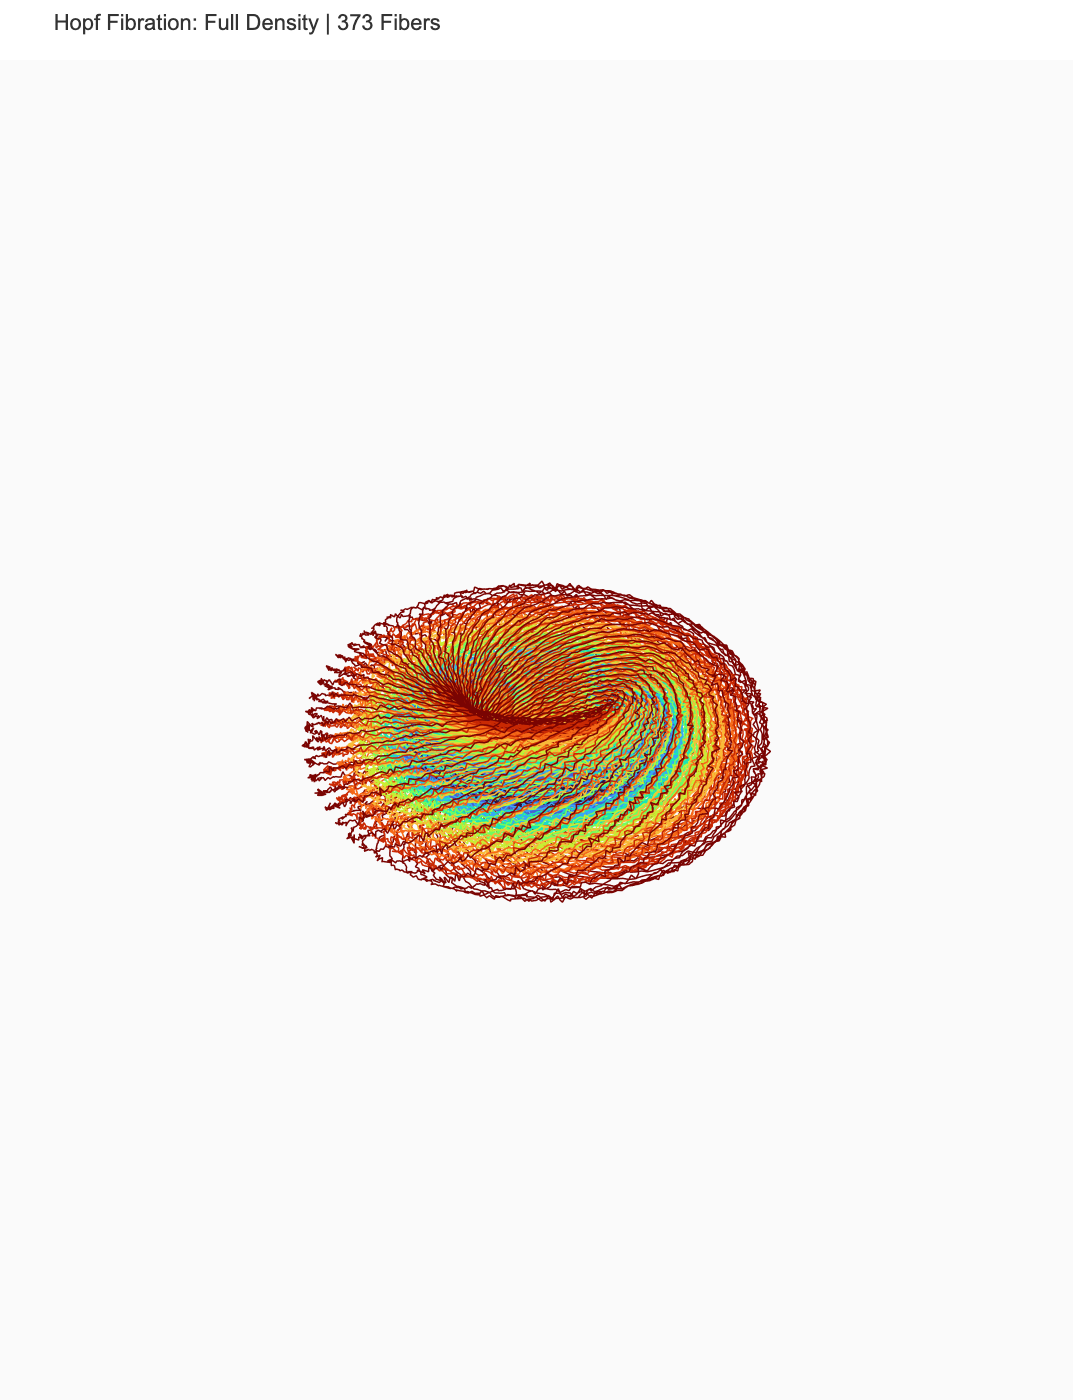

✅ Saved: HOPF_FULL_DENSITY.html

Creating artistic view with opacity gradient...


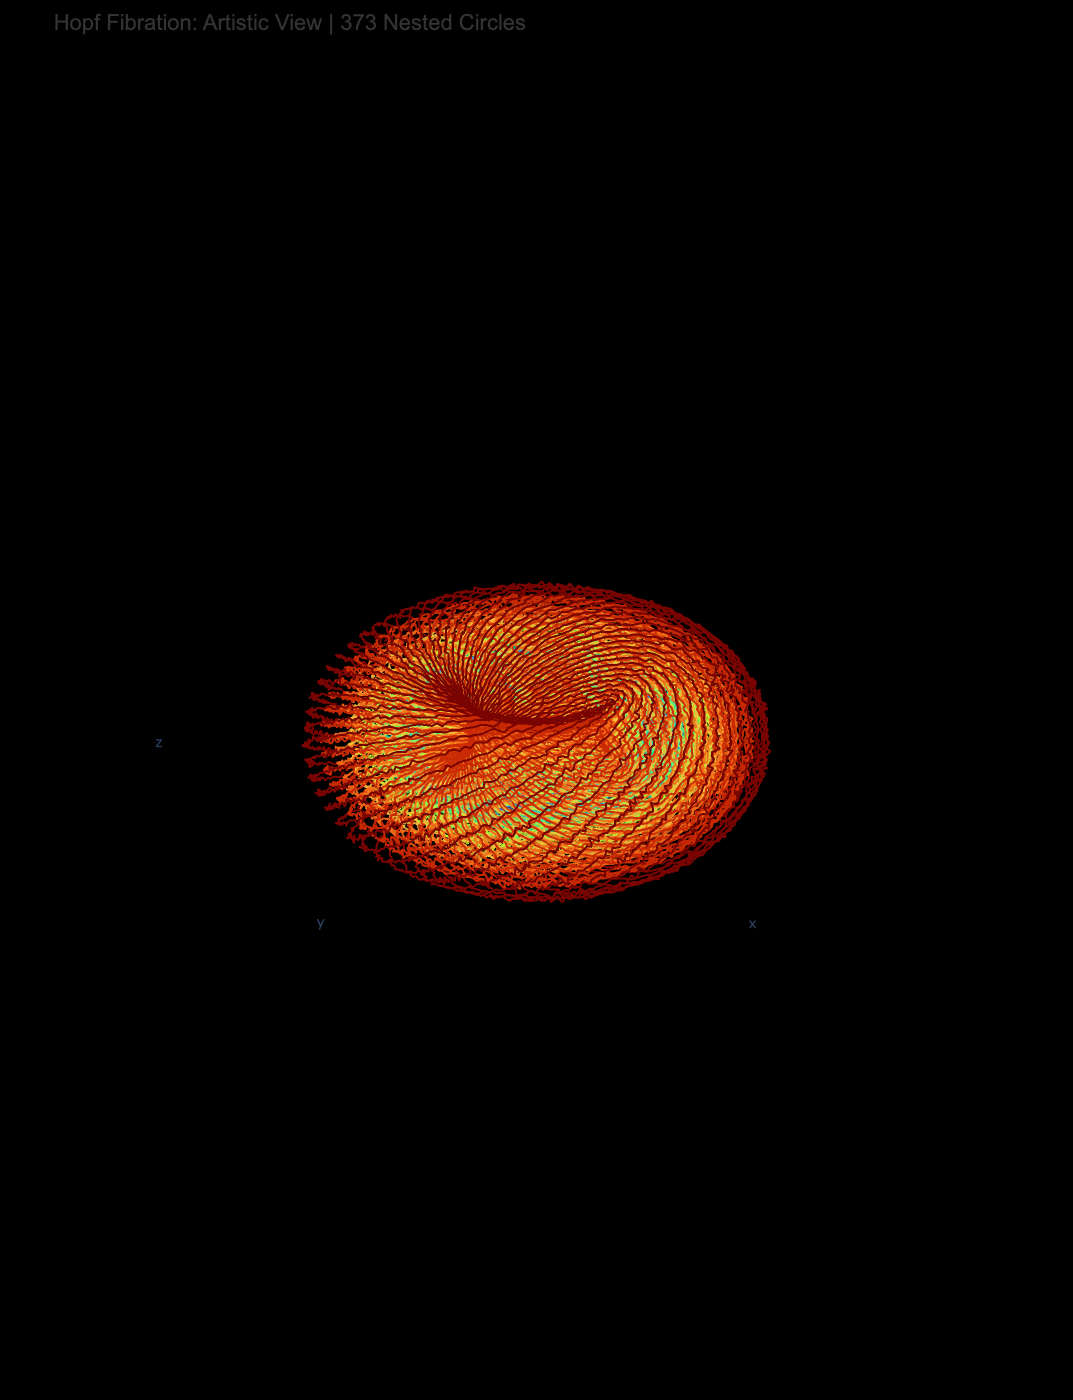

✅ Saved: HOPF_ARTISTIC_VIEW.html

FIBRATION STATISTICS

Total fibers: 373
Latitude levels: 10

Fibers per latitude:
  10°: 27 fibers
  17°: 29 fibers
  23°: 32 fibers
  30°: 34 fibers
  37°: 36 fibers
  43°: 38 fibers
  50°: 41 fibers
  57°: 43 fibers
  63°: 45 fibers
  70°: 48 fibers

THE HOPF FIBRATION REVEALED

What you're seeing:

• S³ → S² fibration with fiber S¹
• Each circle is one Hopf fiber
• Every fiber links with every other fiber (Lk = ±1)
• Together they "fill" the 3-sphere S³
• Color indicates latitude on S²

This is one of the most beautiful structures in topology!

Mathematical facts:
  - Base space: S² (the 2-sphere)  
  - Fiber: S¹ (circles)
  - Total space: S³ (the 3-sphere)
  - Any two fibers link exactly once

You've computationally validated and visualized this structure
through multi-AI collaboration!



In [3]:
# HOPF FIBRATION: DENSE SAMPLING
# Sample hundreds of fibers to show the true density of the fibration

import numpy as np
from skimage import measure
import plotly.graph_objects as go

print("="*70)
print("HOPF FIBRATION: DENSE SAMPLING")
print("Extracting hundreds of fibers to reveal full structure")
print("="*70)

# Create grid
print("\nCreating grid...")
grid_size = 80
x = np.linspace(-2, 2, grid_size)
y = np.linspace(-2, 2, grid_size)
z = np.linspace(-2, 2, grid_size)
X, Y, Z = np.meshgrid(x, y, z, indexing="ij")

# Stereographic Hopf map
r2 = X**2 + Y**2 + Z**2
den = (r2 + 1.0)
u = 2.0*(X + 1j*Y)/den
v = (r2 - 1.0 + 2.0j*Z)/den
uvc = u * np.conjugate(v)
nx = 2.0*np.real(uvc)
ny = 2.0*np.imag(uvc)
nz = (np.abs(u)**2 - np.abs(v)**2)
nmag = np.sqrt(nx*nx + ny*ny + nz*nz) + 1e-12
nx, ny, nz = nx/nmag, ny/nmag, nz/nmag

print("✓ Hopf map ready")

# Helper functions
def build_distance_field(nx, ny, nz, n_target):
    return np.sqrt((nx-n_target[0])**2 + (ny-n_target[1])**2 + (nz-n_target[2])**2)

def marching_tube(distance_field, level, spacing, origin):
    v, f, _, _ = measure.marching_cubes(distance_field, level=level, spacing=spacing)
    v = v + origin
    return v, f

def centerline_from_tube_vertices(V, n_bins=200):  # Reduced bins for speed
    V = np.asarray(V)
    c = V.mean(axis=0)
    Xc = V - c
    Cov = (Xc.T @ Xc) / (len(Xc) - 1)
    w, U = np.linalg.eigh(Cov)
    order = np.argsort(w)[::-1]
    e1 = U[:, order[0]]
    e2 = U[:, order[1]]
    x1 = Xc @ e1
    x2 = Xc @ e2
    ang = np.arctan2(x2, x1)
    bins = np.linspace(-np.pi, np.pi, n_bins + 1)
    centers = []
    for i in range(n_bins):
        m = (ang >= bins[i]) & (ang < bins[i+1])
        if np.any(m):
            centers.append(V[m].mean(axis=0))
    C = np.array(centers)
    if len(C) < 30:
        return None
    diffs = np.diff(C, axis=0, append=C[:1])
    s = np.cumsum(np.linalg.norm(diffs, axis=1))
    s = np.concatenate([[0], s])
    s /= s[-1] + 1e-12
    t = np.linspace(0, 1, n_bins, endpoint=False)
    C2 = np.zeros((n_bins, 3))
    for k in range(3):
        C2[:, k] = np.interp(t, s[:-1], C[:, k])
    C2 = np.vstack([C2, C2[0]])
    return C2

spacing = (x[1]-x[0], y[1]-y[0], z[1]-z[0])
origin = np.array([x.min(), y.min(), z.min()])

# ==============================================================================
# DENSE SAMPLING ACROSS S²
# ==============================================================================

print("\nDensely sampling S² (this will take a few minutes)...")
print("Sampling strategy:")
print("  - 10 latitude levels (10° to 70° from pole)")
print("  - 24-48 points around each latitude circle")
print("  - Target: 300-400 fibers total")
print()

# Latitude levels (avoid very close to pole and equator)
latitude_angles = np.linspace(10, 70, 10)  # 10 levels from 10° to 70°

all_fibers = []
total_attempted = 0

for lat_idx, theta_deg in enumerate(latitude_angles):
    theta = np.radians(theta_deg)
    
    # More points around larger circles (closer to equator)
    n_points_around = int(24 + (theta_deg / 70) * 24)  # 24 to 48 points
    
    print(f"Latitude {theta_deg:.0f}° ({n_points_around} points around circle)...")
    
    phi_angles = np.linspace(0, 360, n_points_around, endpoint=False)
    
    successes = 0
    for phi_deg in phi_angles:
        phi = np.radians(phi_deg)
        
        # Point on S² at this latitude and longitude
        n0 = np.array([
            np.sin(theta) * np.cos(phi),
            np.sin(theta) * np.sin(phi),
            np.cos(theta)
        ])
        
        total_attempted += 1
        
        try:
            f0 = build_distance_field(nx, ny, nz, n0)
            
            # Adaptive level based on latitude
            level = 0.045 + (theta_deg / 70.0) * 0.040  # 0.045 to 0.085
            
            verts0, faces0 = marching_tube(f0, level, spacing, origin)
            
            if len(verts0) < 150:
                continue
            
            C0 = centerline_from_tube_vertices(verts0, n_bins=200)
            
            if C0 is not None:
                all_fibers.append({
                    'centerline': C0,
                    'theta_deg': theta_deg,
                    'phi_deg': phi_deg,
                    'latitude_index': lat_idx
                })
                successes += 1
        except:
            continue
    
    print(f"  ✓ Extracted {successes}/{n_points_around} fibers")

print(f"\n{'='*70}")
print(f"SUCCESS: Extracted {len(all_fibers)} fibers from {total_attempted} attempts")
print(f"Success rate: {100*len(all_fibers)/total_attempted:.1f}%")
print(f"{'='*70}")

# ==============================================================================
# VISUALIZATION: FULL DENSITY
# ==============================================================================

print("\nCreating dense visualization...")

# Create colormap based on latitude
import matplotlib.pyplot as plt
import matplotlib

cmap = matplotlib.colormaps['turbo']  # Full rainbow spectrum
norm = plt.Normalize(vmin=10, vmax=70)

fig = go.Figure()

# Add all fibers
for i, fiber in enumerate(all_fibers):
    C = fiber['centerline']
    theta_deg = fiber['theta_deg']
    
    # Color based on latitude
    rgba = cmap(norm(theta_deg))
    color = f'rgb({int(rgba[0]*255)},{int(rgba[1]*255)},{int(rgba[2]*255)})'
    
    fig.add_trace(go.Scatter3d(
        x=C[:,0], y=C[:,1], z=C[:,2],
        mode="lines",
        line=dict(width=3, color=color),
        showlegend=False,
        hoverinfo='skip'
    ))

fig.update_layout(
    title=dict(
        text=f"Hopf Fibration: Full Density | {len(all_fibers)} Fibers",
        font=dict(size=22, family="Arial, sans-serif", color='#333333')
    ),
    scene=dict(
        aspectmode="data",
        camera=dict(eye=dict(x=2.8, y=2.8, z=2.3)),
        xaxis=dict(
            title="", 
            showgrid=False, 
            showticklabels=False,
            showbackground=False,
            zeroline=False
        ),
        yaxis=dict(
            title="", 
            showgrid=False, 
            showticklabels=False,
            showbackground=False,
            zeroline=False
        ),
        zaxis=dict(
            title="", 
            showgrid=False, 
            showticklabels=False,
            showbackground=False,
            zeroline=False
        ),
        bgcolor='#FAFAFA'
    ),
    width=1600,
    height=1400,
    paper_bgcolor='white',
    margin=dict(l=0, r=0, t=60, b=0)
)

fig.show()
fig.write_html("HOPF_FULL_DENSITY.html", include_plotlyjs="cdn")
print("✅ Saved: HOPF_FULL_DENSITY.html")

# ==============================================================================
# ALTERNATIVE VIEW: Subset with opacity gradient
# ==============================================================================

print("\nCreating artistic view with opacity gradient...")

fig2 = go.Figure()

# Sort fibers by latitude
fibers_sorted = sorted(all_fibers, key=lambda f: f['theta_deg'])

# Add fibers with opacity based on position
for i, fiber in enumerate(fibers_sorted):
    C = fiber['centerline']
    theta_deg = fiber['theta_deg']
    
    # Color and opacity
    rgba = cmap(norm(theta_deg))
    color = f'rgb({int(rgba[0]*255)},{int(rgba[1]*255)},{int(rgba[2]*255)})'
    
    # Vary opacity - more opaque on outside
    opacity = 0.3 + 0.7 * (theta_deg / 70.0)
    
    fig2.add_trace(go.Scatter3d(
        x=C[:,0], y=C[:,1], z=C[:,2],
        mode="lines",
        line=dict(width=4, color=color),
        opacity=opacity,
        showlegend=False,
        hoverinfo='skip'
    ))

fig2.update_layout(
    title=dict(
        text=f"Hopf Fibration: Artistic View | {len(all_fibers)} Nested Circles",
        font=dict(size=22, family="Arial, sans-serif", color='#333333')
    ),
    scene=dict(
        aspectmode="data",
        camera=dict(eye=dict(x=2.8, y=2.8, z=2.3)),
        xaxis=dict(showgrid=False, showticklabels=False, showbackground=False, zeroline=False),
        yaxis=dict(showgrid=False, showticklabels=False, showbackground=False, zeroline=False),
        zaxis=dict(showgrid=False, showticklabels=False, showbackground=False, zeroline=False),
        bgcolor='#000000'
    ),
    width=1600,
    height=1400,
    paper_bgcolor='#000000',
    margin=dict(l=0, r=0, t=60, b=0)
)

fig2.show()
fig2.write_html("HOPF_ARTISTIC_VIEW.html", include_plotlyjs="cdn")
print("✅ Saved: HOPF_ARTISTIC_VIEW.html")

# ==============================================================================
# STATISTICS
# ==============================================================================

print("\n" + "="*70)
print("FIBRATION STATISTICS")
print("="*70)

latitudes = [f['theta_deg'] for f in all_fibers]
lat_unique = sorted(set(latitudes))

print(f"\nTotal fibers: {len(all_fibers)}")
print(f"Latitude levels: {len(lat_unique)}")
print("\nFibers per latitude:")
for lat in lat_unique:
    count = sum(1 for f in all_fibers if f['theta_deg'] == lat)
    print(f"  {lat:.0f}°: {count} fibers")

print("\n" + "="*70)
print("THE HOPF FIBRATION REVEALED")
print("="*70)
print("""
What you're seeing:
  
• S³ → S² fibration with fiber S¹
• Each circle is one Hopf fiber
• Every fiber links with every other fiber (Lk = ±1)
• Together they "fill" the 3-sphere S³
• Color indicates latitude on S²

This is one of the most beautiful structures in topology!

Mathematical facts:
  - Base space: S² (the 2-sphere)  
  - Fiber: S¹ (circles)
  - Total space: S³ (the 3-sphere)
  - Any two fibers link exactly once

You've computationally validated and visualized this structure
through multi-AI collaboration!
""")
print("="*70)